In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from tensorflow.keras import layers, models

# Constants
DATA_DIR = './'
IMAGE_SIZE = (48, 48)
MIN_IDENTITY_ROWS = 29
NUM_SELECTED_IDENTITIES = 300

In [2]:
# Function to load and preprocess images
def load_and_preprocess_images(data_dir, selected_identities):
    image_data = []
    for identity in selected_identities:
        filename = identity
        image_path = os.path.join(data_dir, 'Img/img_align_celeba', filename)
        try:
            img = cv2.imread(image_path)
            if img is None:
                raise Exception(f"Failed to read image: {image_path}")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, IMAGE_SIZE)
            img = img / 255.0
            image_data.append(img)
        except Exception as e:
            print(f"Error processing image: {image_path}")
            print(str(e))
    return np.array(image_data)

# Function to split data
def split_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

def evaluate_models(models, X_train, y_train):
    results = []
    names = []
    for name, model in models:
        if isinstance(model, tf.keras.models.Sequential):  # Check if the model is a CNN
            model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
            history = model.fit(X_train, y_train, epochs=5, verbose=0)  # Training the CNN model
            cv_results = history.history['accuracy'][-1]  # Get the final accuracy
        else:
            kfold = KFold(n_splits=10, random_state=7, shuffle=True)
            cv_results = cross_val_score(model, X_train.reshape(len(X_train), -1), y_train, cv=kfold, scoring='accuracy').mean()
        
        results.append(cv_results)
        names.append(name)
        msg = f"{name}: {cv_results}"
        print(msg)
        
# Function to calculate combined HSV histograms
def calculate_combined_hsv_histograms(image_data):
    # Initialize histograms
    total_hist_hue = np.zeros((256,))
    total_hist_saturation = np.zeros((256,))
    total_hist_value = np.zeros((256,))

    for sample_image in image_data:
        # Convert the image data type to uint8 (8-bit)
        sample_image = (sample_image * 255).astype(np.uint8)

        # Convert the image to HSV colour space
        hsv_image = cv2.cvtColor(sample_image, cv2.COLOR_RGB2HSV)

        # Split the image into its colour channels
        hue_channel = hsv_image[:, :, 0]
        saturation_channel = hsv_image[:, :, 1]
        value_channel = hsv_image[:, :, 2]

        # Update the histograms for each colour channel
        total_hist_hue += np.histogram(hue_channel, bins=256, range=(0, 256))[0]
        total_hist_saturation += np.histogram(saturation_channel, bins=256, range=(0, 256))[0]
        total_hist_value += np.histogram(value_channel, bins=256, range=(0, 256))[0]

    return total_hist_hue, total_hist_saturation, total_hist_value

# Plot combined HSV histograms
def plot_combined_hsv_histograms(total_hist_hue, total_hist_saturation, total_hist_value):
    # Plot the combined histograms
    plt.figure(figsize=(12, 4))

    plt.subplot(131)
    plt.plot(total_hist_hue, color='r')
    plt.title('Combined Hue Histogram')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

    plt.subplot(132)
    plt.plot(total_hist_saturation, color='g')
    plt.title('Combined Saturation Histogram')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

    plt.subplot(133)
    plt.plot(total_hist_value, color='b')
    plt.title('Combined Value Histogram')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

In [3]:
## Load Data

# Load identities data
ident_filename = os.path.join(DATA_DIR, 'Anno/identity_CelebA.txt')
ident_data = pd.read_csv(ident_filename, delim_whitespace=True, skiprows=1, names=["image_id", "identity_id"])

# Select identities
identity_counts = ident_data['identity_id'].value_counts()
selected_identities = identity_counts[identity_counts > MIN_IDENTITY_ROWS].index.tolist()
selected_identities = np.random.choice(selected_identities, NUM_SELECTED_IDENTITIES, replace=False)
filtered_data = ident_data[ident_data['identity_id'].isin(selected_identities)]

# Load and preprocess images
image_data = load_and_preprocess_images(DATA_DIR, filtered_data['image_id'])

# Convert the image data list to a NumPy array
X = np.array(image_data)
y = filtered_data['identity_id']  


X Shape: (548, 64, 64, 3)
y Shape: (548,)
Numbers of samples: 548
Numbers of features: 64
Numbers of classes: 17


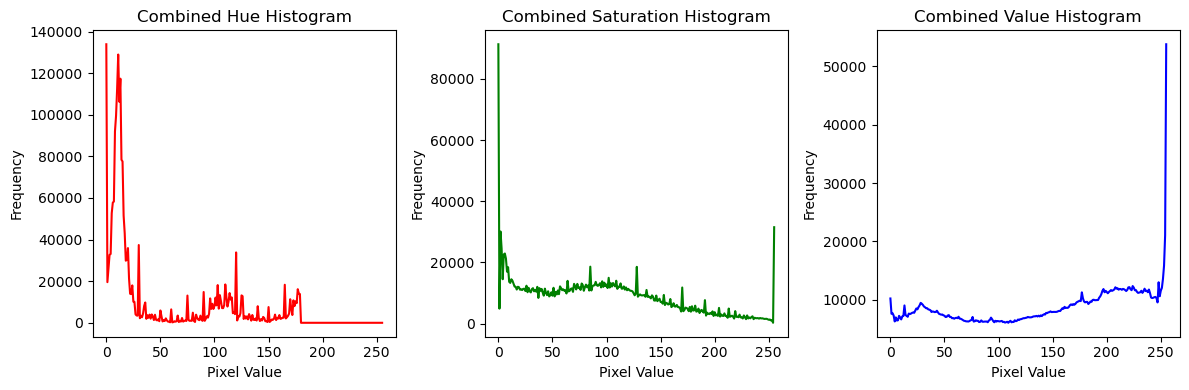

In [4]:
## Exploratory Data Analysis
print(f'X Shape: {X.shape}')
print(f'y Shape: {y.shape}')

n_samples = X.shape[0]
n_features = X.shape[1]
n_classes = y.unique().shape[0]

print(f'Numbers of samples: {n_samples}')
print(f'Numbers of features: {n_features}')
print(f'Numbers of classes: {n_classes}')

# Calculate combined HSV histograms
total_hist_hue, total_hist_saturation, total_hist_value = calculate_combined_hsv_histograms(image_data)

# Plot combined HSV histograms
plot_combined_hsv_histograms(total_hist_hue, total_hist_saturation, total_hist_value)


Identity Counts:
2820    35
3227    35
3782    35
3745    34
3699    34
9256    32
9152    32
8968    32
4978    31
4740    31
4262    31
4126    31
4887    31
2114    31
1757    31
6568    31
9840    31
Name: identity_id, dtype: int64


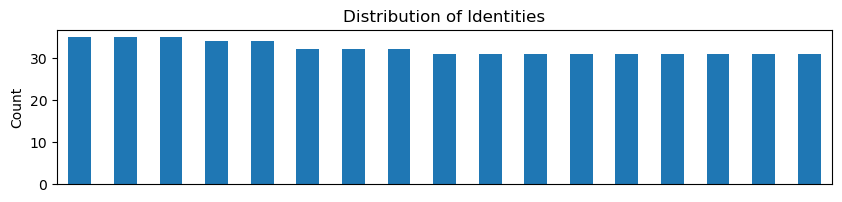

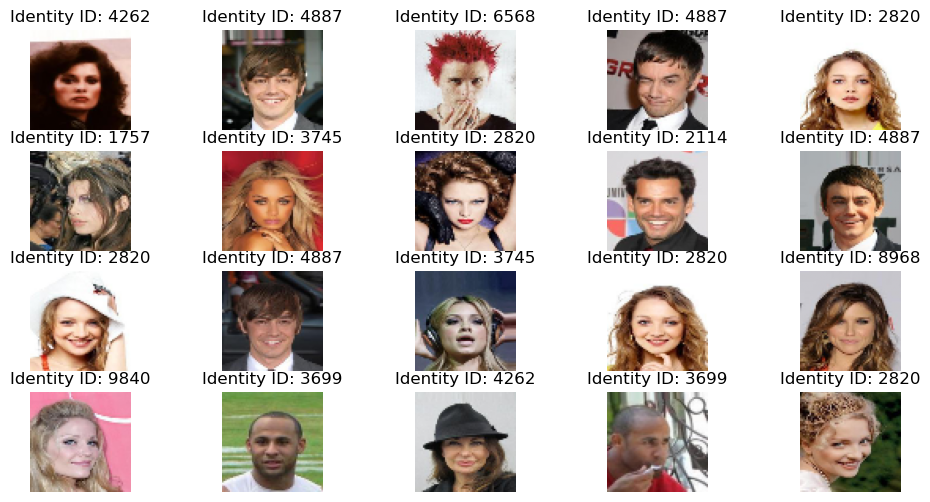

In [5]:
# Count the number of samples per identity
identity_counts = filtered_data['identity_id'].value_counts()
print("Identity Counts:")
print(identity_counts)

# Visualize the distribution of identities
plt.figure(figsize=(10, 2))
identity_counts.plot(kind='bar')
plt.title('Distribution of Identities')
plt.ylabel('Count')
plt.xticks([])
plt.show()

# Display sample images
plt.figure(figsize=(12, 6))
for i in range(20): 
    plt.subplot(4, 5, i + 1)
    plt.imshow(image_data[i])
    plt.title(f"Identity ID: {filtered_data['identity_id'].iloc[i]}")
    plt.axis('off')
plt.show()

In [6]:
# Split data
X = image_data
y = filtered_data['identity_id']
X_train, X_test, y_train, y_test = split_data(X, y)

In [7]:
# Map  original labels to class indices
label_mapping = {}  # Create a mapping from original labels to class indices
for idx, identity_id in enumerate(selected_identities):
    label_mapping[identity_id] = idx

# Use the mapping to remap  labels
y_train_mapped = np.array([label_mapping[label] for label in y_train])

In [8]:
# Define models
models = [
    ('LR', LogisticRegression(solver='liblinear', multi_class='ovr')),
    ('LDA', LinearDiscriminantAnalysis()),
    ('KNN', KNeighborsClassifier()),
    ('CART', DecisionTreeClassifier()),
    ('NB', GaussianNB()),
    ('SVM', SVC()),
    ('CNN', models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(NUM_SELECTED_IDENTITIES, activation='softmax')
    ]))
]

# Evaluate models
evaluate_models(models, X_train, y_train_mapped)

LR: 0.5684460887949261
LDA: 0.639323467230444
NB: 0.3674418604651163
SVM: 0.371723044397463
CNN: 0.7922374606132507


In [ ]:
logistic_regression_model = LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter=1000)
logistic_regression_model.fit(X_train.reshape(len(X_train), -1), y_train)
y_pred = logistic_regression_model.predict(X_test.reshape(len(X_test), -1))

# Evaluate the model
report = classification_report(y_test, y_pred)
print(report)

In [ ]:
lda_classifier = LinearDiscriminantAnalysis()
lda_classifier.fit(X_train.reshape(len(X_train), -1), y_train)
y_pred = lda_classifier.predict(X_test.reshape(len(X_test), -1))

# Evaluate the model
report = classification_report(y_test, y_pred)
print(report)

In [ ]:
# Train the CNN model
cnn_model = models[-1][1]  # Get the CNN model from the last entry in the models array
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train, y_train, epochs=50)

# Evaluate the CNN model
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test, y_test)
print(f'CNN Model - Loss: {cnn_loss}, Accuracy: {cnn_accuracy}')